# Code for loading in the datasets and modelling

In [1]:
#from loader import list_files, Files, Folders  #precalculate what we are loading in
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sys import getsizeof
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [3]:
import opendatasets as od
dataset = 'https://www.kaggle.com/datasets/dextershepherd/texture-tactip'
# Using opendatasets let's download the data sets
od.download(dataset)

ModuleNotFoundError: No module named 'opendatasets'

## Load in data

In [2]:
class loaded:
    def __init__(self,t=20):
        data = np.load("/its/home/drs25/Documents/data/Tactile Dataset/datasets/X_textures_all15.npz") #load data
        for array_name in data:
            self.X=(data[array_name].astype(np.uint8))
        data = np.load("/its/home/drs25/Documents/data/Tactile Dataset/datasets/y_textures_all15.npz") #load data
        for array_name in data:
            self.y=(data[array_name].astype(np.uint8))
        self.keys={}
        self.files=['wool', 'LacedMatt', 'Gfoam', 'bubble', 'Efoam', 'cotton', 'Flat', 'felt', 'Ffoam']
        for i, name in enumerate(self.files):
            self.keys[i]=name
        self.keys={'Leather': 34, 'Cork': 41, 'wool': 21, 'LacedMatt': 31, 'Gfoam': 33, 'Plastic': 22, 'Carpet': 35, 'bubble': 40, 'Efoam': 24, 'cotton': 32, 'LongCarpet': 28, 'Flat': 17, 'felt': 37, 'Jeans': 42, 'Ffoam': 39}
        print("Dataset size:",self.X.shape[0],"\nWindow size:",self.X.shape[1],"\nImage:",self.X.shape[2:])
        print("Memory needed:",round(getsizeof(self.X)/ 1024 / 1024/ 1024,2),"GB")
        assert self.X.shape[0]==self.y.shape[0],"Incorrect data size match y="+str(self.y.shape[0])+" x="+str(self.X.shape[0])
        self.X=self.X[:,0:t]
        #randomize order
        n_samples = self.X.shape[0]
        indices = np.random.permutation(n_samples)
        shuffled_data = self.X[indices]
        shuffled_labels = self.y[indices]
        self.X=shuffled_data
        self.y=shuffled_labels
    def augment(self):
        #create rotations
        self.AugmentedX=np.zeros((len(self.X)*3,*self.X.shape[1:]),dtype=np.uint8)
        self.Augmentedy=np.zeros_like(np.concatenate((self.y,self.y,self.y)))
        for k,i in enumerate(range(0,len(self.AugmentedX),3)): #loop through the normal data and new data
            for j in range(len(self.X[0])):
                self.AugmentedX[i][j]=np.copy(self.X[k][j])
                self.AugmentedX[i+1][j]=cv2.resize(cv2.rotate(self.X[k][j].copy(), cv2.ROTATE_90_CLOCKWISE),(self.X[k][j].shape[1],self.X[k][j].shape[0]),interpolation=cv2.INTER_AREA)
                self.AugmentedX[i+2][j]=cv2.resize(cv2.rotate(self.X[k][j].copy(), cv2.ROTATE_180),(self.X[k][j].shape[1],self.X[k][j].shape[0]),interpolation=cv2.INTER_AREA)
                self.Augmentedy[i+1]=self.y[k]
                self.Augmentedy[i+2]=self.y[k]
                self.Augmentedy[i]=self.y[k]
                #self.AugmentedX[i+3][j]=cv2.rotate(self.X[k][j], cv2.ROTATE_90_COUNTERCLOCKWISE)
        print("Dataset size:",self.AugmentedX.shape[0],"\nWindow size:",self.X.shape[1],"\nImage:",self.X.shape[2:])
        print("Memory needed:",round(getsizeof(self.AugmentedX)/ 1024 / 1024/ 1024,2),"GB")
        del self.X
        del self.y
    def applySobel(self):
        for i in range(len(self.X)): #crop all images individually
            for j in range(len(self.X[0])):
                image=self.X[i][j]
                # Apply Sobel filter in x-direction
                sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # ksize=3 for a 3x3 Sobel kernel

                # Apply Sobel filter in y-direction
                sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

                # Convert the results back to uint8
                sobel_x = np.uint8(np.absolute(sobel_x))
                sobel_y = np.uint8(np.absolute(sobel_y))

                # Combine the results to get the final edge-detected image
                sobel_combined = cv2.bitwise_or(sobel_x, sobel_y)
                self.X[i][j]=sobel_combined
data=loaded(t=10)
data.applySobel()
#data.augment()

: 

: 

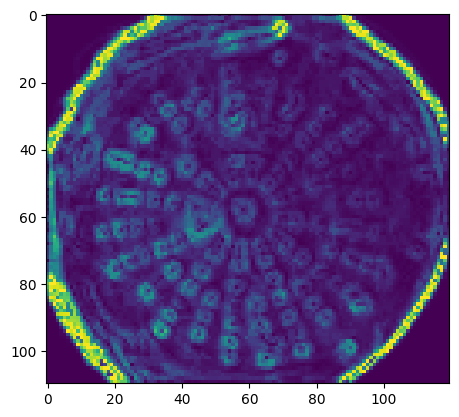

In [3]:
plt.imshow(data.X[0][0])
plt.show()
#plt.savefig("test.png")

In [ ]:
data.applySobel()

KeyError: 10

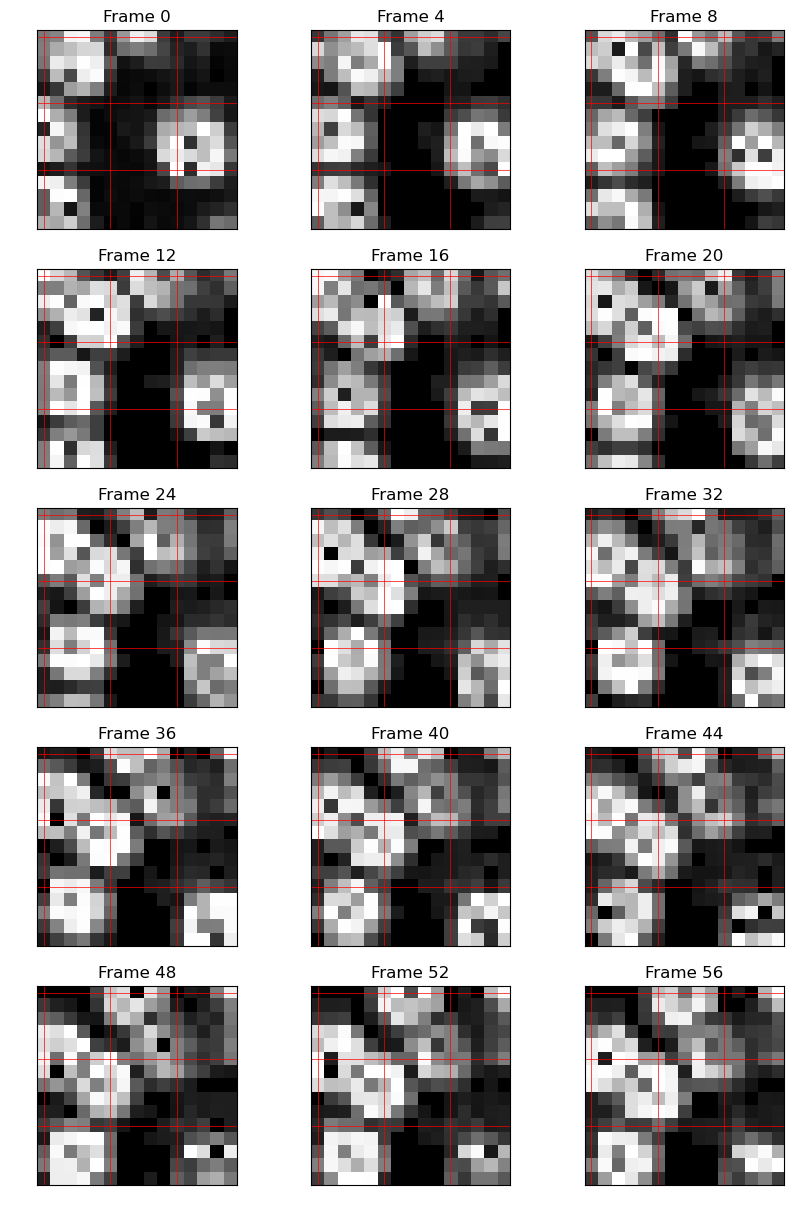

In [ ]:
num_images = 15
texture=np.random.randint(0,100)
images = data.X[texture][0:15]

num_rows = 5
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 15))

# Flatten the axes array for easy indexing
axes = axes.flatten()
ax = axes[0]
ax.set_title("Frame "+str(0))
ax.imshow(images[0][50:65,50:65], cmap='gray')
ax.set_xticks(np.arange(0, 15, 5))
# Set custom ticks for y-axis (every 10 units)
ax.set_yticks(np.arange(0, 15, 5))
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.grid(True, which='both', axis='both', color='r', linestyle='-', linewidth=0.5)
# Plot each image
imageA=images[0].astype(np.uint8)
kernel=np.array((9,9))
for i in range(1,num_images):
    imageB=images[i].astype(np.uint8)
    imageB[imageB<20]=0

    ax = axes[i]
    ax.imshow(imageB[50:65,50:65],cmap="gray")
    #ax.axis('off')
    ax.set_xticks(np.arange(0, 15, 5))
    # Set custom ticks for y-axis (every 10 units)
    ax.set_yticks(np.arange(0, 15, 5))
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.grid(True, which='both', axis='both', color='r', linestyle='-', linewidth=0.5)
    ax.set_title("Frame "+str(i*4))
    

# Remove any empty subplots
for i in range(num_images, num_rows*num_cols):
    fig.delaxes(axes[i])

plt.suptitle("Flow of "+str(data.keys[data.y[texture]]))
plt.tight_layout()
plt.savefig("/its/home/drs25/Pictures/TacTip real/rigData/centrepointMove.pdf")
plt.show()

## Look at spread of changes

In [ ]:
#change=[np.zeros((len(data.X[0]))) for i in range(len(data.keys))]
change=np.zeros((len(data.X),41,20))
counter=[0 for i in range(len(data.keys))]
for i in range(len(data.X)):
    y=data.y[i]
    framesA=data.X[i][0:-2].reshape(data.X[i].shape[0], -1)
    framesB=data.X[i][1:-1].reshape(data.X[i].shape[0], -1)
    difference=np.abs(np.sum(framesA-framesB,axis=1))
    change[y][counter[y]]=difference
    counter[y]+=1

change=(np.array(change).T/np.array(counter)).T
change.shape

IndexError: list index out of range

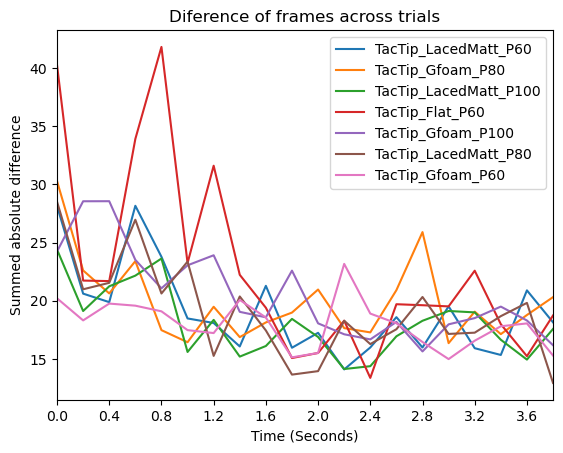

In [ ]:
av=np.average(change,axis=1)
for i in range(len(change)):
    plt.plot(av[i],label=data.keys[i])

plt.legend(loc="upper right")
plt.xticks([i for i in range(0,len(change[2]),int(len(data.X[0])*0.1))], labels=[round((4/len(data.X[0]))*i,2) for i in range(0,len(change[2]),int(len(data.X[0])*0.1))])
plt.xlabel("Time (Seconds)")
plt.xlim([0,19])
plt.ylabel("Summed absolute difference")
plt.title("Diference of frames across trials")
plt.show()

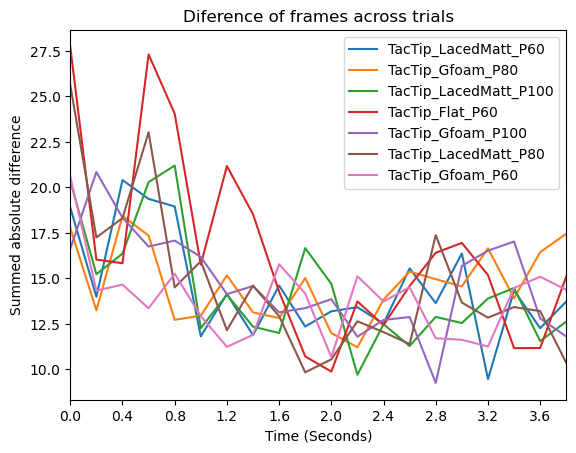

In [ ]:
av=np.std(change,axis=1)
for i in range(len(change)):
    plt.plot(av[i],label=data.keys[i])

plt.legend(loc="upper right")
plt.xticks([i for i in range(0,len(change[2]),int(len(data.X[0])*0.1))], labels=[round((4/len(data.X[0]))*i,2) for i in range(0,len(change[2]),int(len(data.X[0])*0.1))])
plt.xlabel("Time (Seconds)")
plt.xlim([0,19])
plt.ylabel("Summed absolute difference")
plt.title("Diference of frames across trials")
plt.show()

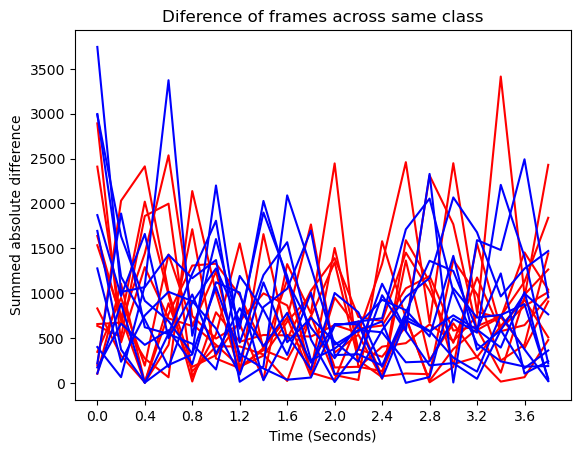

In [ ]:
found=0
i=0
while found<10:
    y=data.y[i]
    if y==0:
        framesA=data.X[i][0:-2].reshape(data.X[i].shape[0], -1)
        framesB=data.X[i][1:-1].reshape(data.X[i].shape[0], -1)
        difference=np.abs(np.sum(framesA-framesB,axis=1))
        plt.plot(difference,c="r")
        found+=1
    i+=1
i=0
found=0
while found<10:
    y=data.y[i]
    if y==5:
        framesA=data.X[i][0:-2].reshape(data.X[i].shape[0], -1)
        framesB=data.X[i][1:-1].reshape(data.X[i].shape[0], -1)
        difference=np.abs(np.sum(framesA-framesB,axis=1))
        plt.plot(difference,c="b")
        found+=1
    i+=1

plt.xticks([i for i in range(0,len(change[0]),int(len(data.X[0])*0.1))], labels=[round((4/len(data.X[0]))*i,2) for i in range(0,len(change[0]),int(len(data.X[0])*0.1))])
plt.xlabel("Time (Seconds)")
plt.ylabel("Summed absolute difference")
plt.title("Diference of frames across same class")
plt.show()
    

# Machine learning
## Regression
### Ridge

In [180]:
reformed_X=data.X[:,:4].reshape(len(data.X[:,:4]),4*110*120) 
n=int(len(data.X)/3)
train_X=reformed_X[:n]
train_y=data.y[:n]
test_X=reformed_X[n:n+2000]
test_y=data.y[n:n+2000]
print(n,test_X.shape,train_X.shape)

1600 (2000, 52800) (1600, 52800)


In [12]:
alpha = 1.0  # Regularization parameter

# Define the Ridge regression model
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(train_X, train_y)
predictions = np.round(ridge_model.predict(test_X))
a=predictions.astype(np.int8)-test_y.astype(np.int8)
correct=len(a[a==0])
print("Accuracy",correct/len(a)*100,"%")
print("average loss",np.sum(np.absolute(np.round(predictions)-test_y))/len(predictions))

Accuracy 72.55 %
average loss 0.293


In [14]:
# t exp
alpha = 1.0 
t_ridge_train=[]
t_ridge_test=[]
for i in range(1,20,1):
    d=data.X[:,:i]
    reformed_X=data.X[:,:4].reshape(len(data.X[:,:4]),4*110*120) 
    n=int(len(data.X)/3)
    train_X=reformed_X[:n]
    train_y=data.y[:n]
    test_X=reformed_X[n:n+2000]
    test_y=data.y[n:n+2000]
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(train_X, train_y)
    predictionsX = ridge_model.predict(train_X)
    predictions = ridge_model.predict(test_X)
    a=(predictionsX.astype(np.int8)-train_y.astype(np.int8))
    t_ridge_train.append(len(a[a==0])/len(a))
    a=(predictions.astype(np.int8)-test_y.astype(np.int8))
    t_ridge_test.append(len(a[a==0])/len(a))
    print("accuracy at",i,":",(len(a[a==0])/len(a))*100,"%")
    del d
    del train_X
    del test_X
    del ridge_model
t_ridge_test=np.array(t_ridge_test)
t_ridge_train=np.array(t_ridge_train)
print(t_ridge_test,t_ridge_test.dtype)
np.save("/its/home/drs25/RoboSkin/Code/NewRigExperiments/data/t_ridge_train",t_ridge_train)
np.save("/its/home/drs25/RoboSkin/Code/NewRigExperiments/data/t_ridge_test",t_ridge_test)

accuracy at 1 : 45.88888888888889 %
accuracy at 2 : 49.44444444444444 %
accuracy at 3 : 48.333333333333336 %
accuracy at 4 : 48.888888888888886 %
accuracy at 5 : 48.55555555555556 %
accuracy at 6 : 48.66666666666667 %
accuracy at 7 : 48.22222222222222 %
accuracy at 8 : 48.44444444444444 %


In [ ]:
print("Accuracy:",(len(predictions)-np.sum(np.absolute(np.absolute(np.round(predictions)-test_y))))/len(predictions),"%")
print("average loss",np.sum(np.absolute(np.round(predictions)-test_y))/len(predictions))

Accuracy: 0.6411111111111111 %
average loss 0.35888888888888887


### Linear

In [ ]:
reformed_X=data.X.reshape(4800,20*110*120)
train_X=reformed_X[:2000]
train_y=data.y[0:2000]
test_X=reformed_X[2000:2900]
test_y=data.y[2000:2900]
print(test_X.shape,train_X.shape)

(900, 264000) (2000, 264000)


In [ ]:
linear_model = LinearRegression()

# Fit the model
linear_model.fit(train_X, train_y)
predictions = linear_model.predict(test_X)
print("Accuracy:",(len(predictions)-np.sum(np.absolute(np.absolute(np.round(predictions)-test_y))))/len(predictions),"%")
print("average loss",np.sum(np.absolute(np.round(predictions)-test_y))/len(predictions))

Accuracy: 0.7588888888888888 %
average loss 0.2411111111111111


In [7]:
# t exp
t_lin_train=[]
t_lin_test=[]
for i in range(1,12,1):
    d=data.AugmentedX[:,:i]
    reformed_X=d.reshape(len(data.AugmentedX),(i)*110*120) 
    train_X=reformed_X[:3000]
    train_y=data.Augmentedy[0:3000]
    test_X=reformed_X[3000:3900]
    test_y=data.Augmentedy[3000:3900]
    linear_model = LinearRegression()
    linear_model.fit(train_X, train_y)
    predictionsX = linear_model.predict(train_X)
    predictions = linear_model.predict(test_X)
    a=(predictionsX.astype(np.uint8)-train_y)
    t_lin_train.append(len(a[a==0])/len(a))
    a=(predictions.astype(np.uint8)-test_y)
    t_lin_test.append(len(a[a==0])/len(a))
    del d
    del train_X
    del test_X
    del linear_model
t_lin_test=np.array(t_lin_test)
t_lin_train=np.array(t_lin_train)
np.save("/its/home/drs25/RoboSkin/Code/NewRigExperiments/data/t_lin_train_augmented",t_lin_train)
np.save("/its/home/drs25/RoboSkin/Code/NewRigExperiments/data/t_lin_test_augmented",t_lin_test)

### Random forest

In [ ]:
reformed_X=data.X.reshape(4800,4*110*120)
train_X=reformed_X[:2000]
train_y=data.y[0:2000]
test_X=reformed_X[2000:2900]
test_y=data.y[2000:2900]
print(test_X.shape,train_X.shape)

(900, 264000) (2000, 264000)


In [183]:
# Define the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=25, random_state=42)

# Fit the model
rf_model.fit(train_X, train_y)

predictions = rf_model.predict(test_X)
print("Accuracy:",(len(predictions)-np.sum(np.absolute(np.absolute(np.round(predictions)-test_y))))/len(predictions),"%")
print("average loss",np.sum(np.absolute(np.round(predictions)-test_y))/len(predictions))
np.save("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/test_y",test_y)
np.save("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/predictionsRandomForest",predictions)

Accuracy: 0.7105 %
average loss 0.2895


In [4]:
# t exp
t_for_train=[]
t_for_test=[]
for i in range(1,12,1):
    print(i)
    d=data.AugmentedX[:,:i]
    reformed_X=d.reshape(len(data.AugmentedX),(i)*110*120) 
    train_X=reformed_X[:3000]
    train_y=data.Augmentedy[0:3000]
    test_X=reformed_X[3000:3900]
    test_y=data.Augmentedy[3000:3900]
    rf_model = RandomForestRegressor(n_estimators=25, random_state=42)
    # Fit the model
    rf_model.fit(train_X, train_y)
    predictionsX = np.round(rf_model.predict(train_X))
    predictions = np.round(rf_model.predict(test_X))
    a=(predictionsX.astype(np.uint8)-train_y)
    t_for_train.append(len(a[a==0])/len(a))
    a=(predictions.astype(np.uint8)-test_y)
    t_for_test.append(len(a[a==0])/len(a))
    del d
    del train_X
    del test_X
    del rf_model
t_for_test=np.array(t_for_test)
t_for_train=np.array(t_for_train)
np.save("/its/home/drs25/RoboSkin/Code/NewRigExperiments/data/t_for_train_augmented",t_for_train)
np.save("/its/home/drs25/RoboSkin/Code/NewRigExperiments/data/t_for_test_augmented",t_for_test)

1
2
3
4
5
6
7
8
9
10
11


### Visualising regression

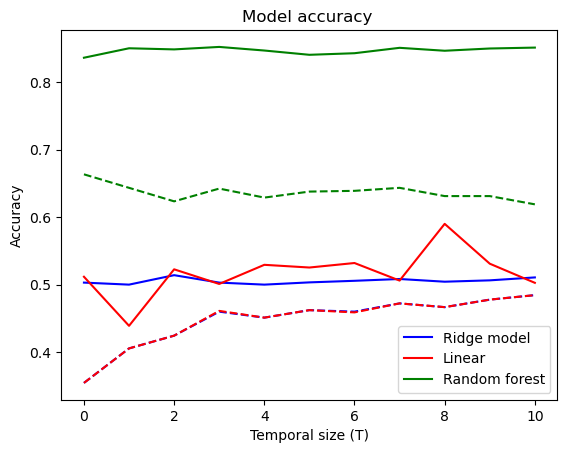

In [8]:
t_ridge_test=np.load("/its/home/drs25/RoboSkin/Code/NewRigExperiments/data/t_ridge_test_augmented.npy")
t_ridge_train=np.load("/its/home/drs25/RoboSkin/Code/NewRigExperiments/data/t_ridge_train_augmented.npy")
t_lin_test=np.load("/its/home/drs25/RoboSkin/Code/NewRigExperiments/data/t_lin_test_augmented.npy")
t_lin_train=np.load("/its/home/drs25/RoboSkin/Code/NewRigExperiments/data/t_lin_train_augmented.npy")
t_for_test=np.load("/its/home/drs25/RoboSkin/Code/NewRigExperiments/data/t_for_test_augmented.npy")
t_for_train=np.load("/its/home/drs25/RoboSkin/Code/NewRigExperiments/data/t_for_train_augmented.npy")
plt.plot(t_ridge_train,c="b",label="Ridge model")
plt.plot(t_ridge_test,"--",c="b")
plt.plot(t_lin_train,c="r",label="Linear")
plt.plot(t_lin_test,"--",c="r")
plt.plot(t_for_test,"--",c="g")
plt.plot(t_for_train,c="g",label="Random forest")
plt.legend(loc="lower right")
plt.xlabel("Temporal size (T)")
plt.ylabel("Accuracy")
plt.title("Model accuracy ")
plt.show()

In [20]:
n=int(len(data.AugmentedX)/4)
reformed_X=data.AugmentedX[0:n+2000,:].reshape(len(data.AugmentedX[0:n+2000,:]),4*110*120)
scaler = StandardScaler()
reformed_X = scaler.fit_transform(reformed_X)
n_components = 5
pca = PCA(n_components=n_components)
reformed_X = pca.fit_transform(reformed_X)
n=int(len(data.AugmentedX)/4)
train_X=reformed_X[:n]
train_y=data.Augmentedy[:n]
test_X=reformed_X[n:n+2000]
test_y=data.Augmentedy[n:n+2000]
print(test_X.shape,train_X.shape)
alpha = 1.0  # Regularization parameter
# Analyze the explained variance
explained_variance = pca.explained_variance_ratio_
print(f'Explained variance by each component: {explained_variance}')
print(f'Total explained variance: {np.sum(explained_variance)}')

ValueError: cannot reshape array of size 792000000 into shape (5000,52800)

In [4]:
model_acc=np.zeros((3,len(range(100,3000,250)),))
for i,n_components in enumerate(range(100,3000,250)):
    print(i,n_components)
    n=int(len(data.AugmentedX)/4)
    yn=2000
    t=7
    reformed_X=data.AugmentedX[0:n+yn,:t].reshape(len(data.AugmentedX[0:n+yn,:t]),t*110*120)
    scaler = StandardScaler()
    reformed_X = scaler.fit_transform(reformed_X)

    pca = PCA(n_components=n_components)
    reformed_X = pca.fit_transform(reformed_X)
    n=int(len(data.AugmentedX)/4)
    train_X=reformed_X[:n]
    train_y=data.Augmentedy[:n]
    test_X=reformed_X[n:n+yn]
    test_y=data.Augmentedy[n:n+yn]
    #np.save("/its/home/drs25/RoboSkin/Code/NewRigExperiments/data/testy_augmented",test_y)
    print(test_X.shape,train_X.shape)
    explained_variance = pca.explained_variance_ratio_
    #print(f'Explained variance by each component: {explained_variance}')
    print(f'Total explained variance: {np.sum(explained_variance)}')
    alpha = 1.0  # Regularization parameter

    #create best models
    print("RF")
    rf_model = RandomForestRegressor(n_estimators=25, random_state=42)
    rf_model.fit(train_X, train_y)
    predictionsA = np.round(rf_model.predict(test_X))
    a=(predictionsA.astype(np.uint8)-test_y)
    model_acc[0][i]= (len(a[a==0]))/len(predictionsA)
    #np.save("/its/home/drs25/RoboSkin/Code/NewRigExperiments/data/predictionsA_augmented",predictionsA)
    del rf_model
    print("LR")
    linear_model = LinearRegression()
    linear_model.fit(train_X, train_y)
    predictionsB = np.round(linear_model.predict(test_X)).astype(np.uint8)
    a=(predictionsB.astype(np.uint8)-test_y)
    model_acc[0][i]= (len(a[a==0]))/len(predictionsB)
    #np.save("/its/home/drs25/RoboSkin/Code/NewRigExperiments/data/predictionsB_augmented",predictionsB)
    del linear_model
    print("RR")
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(train_X, train_y)
    predictionsC = np.round(ridge_model.predict(test_X))
    a=(predictionsC.astype(np.uint8)-test_y)
    model_acc[0][i]= (len(a[a==0]))/len(predictionsC)
    #np.save("/its/home/drs25/RoboSkin/Code/NewRigExperiments/data/predictionsC_augmented",predictionsC)
    a=(predictionsC-test_y).astype(np.int8)
    correct=len(a[a==0])
    print("Accuracy",correct/len(a))
    del ridge_model
    np.save("/its/home/drs25/RoboSkin/Code/NewRigExperiments/data/PCA size",model_acc)

#predictions

0 100
(2000, 100) (3600, 100)
Total explained variance: 0.9037140763648767
RF
LR
RR
Accuracy 0.256
1 350
(2000, 350) (3600, 350)
Total explained variance: 0.9271198048032101
RF
LR
RR
Accuracy 0.4955
2 600
(2000, 600) (3600, 600)
Total explained variance: 0.935845836818617
RF
LR
RR
Accuracy 0.577
3 850
(2000, 850) (3600, 850)
Total explained variance: 0.9424687332324968
RF
LR
RR
Accuracy 0.5865
4 1100
(2000, 1100) (3600, 1100)
Total explained variance: 0.9481622190441406
RF
LR
RR
Accuracy 0.5725
5 1350
(2000, 1350) (3600, 1350)
Total explained variance: 0.9532933926227056
RF
LR
RR
Accuracy 0.554
6 1600
(2000, 1600) (3600, 1600)
Total explained variance: 0.9579931629321936
RF
LR
RR
Accuracy 0.548
7 1850
(2000, 1850) (3600, 1850)
Total explained variance: 0.962351149365539
RF
LR
RR
Accuracy 0.5025
8 2100
(2000, 2100) (3600, 2100)
Total explained variance: 0.9664020019621066
RF
LR
RR
Accuracy 0.4655
9 2350
(2000, 2350) (3600, 2350)
Total explained variance: 0.9701820880968062
RF
LR
RR
Accu

12 16


ValueError: x and y must have same first dimension, but have shapes (12,) and (16,)

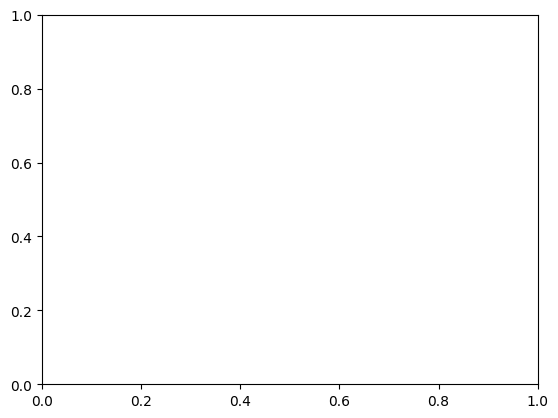

In [7]:
print(len(range(100,3000,250)),len(model_acc[0]))
plt.plot(range(100,3000,250),model_acc[0])
plt.plot(range(100,3000,250),model_acc[1])
plt.plot(range(100,3000,250),model_acc[2])
plt.show()

In [ ]:
np.save("/its/home/drs25/GitHub/RoboSkin/Code/NewRigExperiments/data/testy_augmented",test_y)

In [24]:
a=(predictionsC-test_y).astype(np.int8)
correct=len(a[a==0])
print("Accuracy",correct/len(a))

Accuracy 0.6122222222222222


In [187]:
#predictionsA=np.load("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/predictionsA.npy").astype(np.uint8)
#predictionsB=np.load("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/predictionsB.npy").astype(np.uint8)
predictionsC=np.load("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/predictionsRandomForest.npy").astype(np.uint8)
test_y=np.load("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/test_y.npy")
"""a=(predictionsA-test_y).astype(np.int8)
correct=len(a[a==0])
print("Accuracy",correct/len(a))

a=(predictionsB-test_y).astype(np.int8)
correct=len(a[a==0])
print("Accuracy",correct/len(a))"""

a=(predictionsC-test_y).astype(np.int8)
correct=len(a[a==0])
print("Accuracy",correct/len(a))

Accuracy 0.745


In [ ]:
print(data.AugmentedX[0].shape)
110*120

(4, 110, 120)


13200

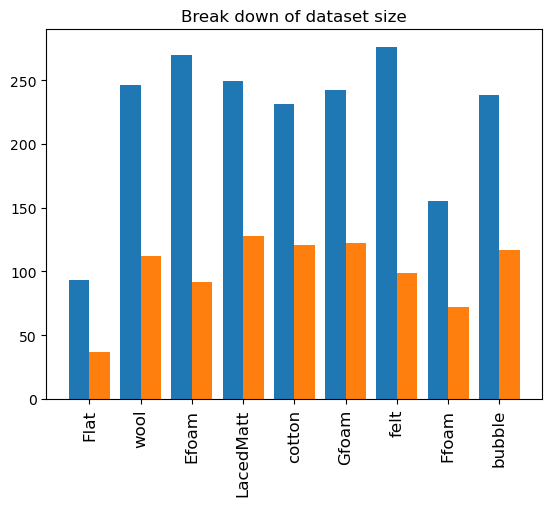

In [ ]:
#show distribution of data classes

num_classes = len(np.unique(train_y))
un=np.unique(test_y)
width = 0.4
indices = np.arange(num_classes)
num_in_classes=np.zeros((num_classes,))
num_in_test=np.zeros((num_classes,))
for i in range(num_classes):
    num_in_classes[i]=len(train_y[train_y==un[i]])
    num_in_test[i]=len(test_y[test_y==un[i]])
plt.bar(indices - width/2, num_in_classes, width, label='Correct')
plt.bar(indices + width/2, num_in_test, width, label='Incorrect')

plt.xticks([j for j in range(num_classes)],[data.keys[np.unique(test_y)[j]] for j in range(num_classes)],rotation=90,fontsize=12)
plt.title("Break down of dataset size")
plt.show()

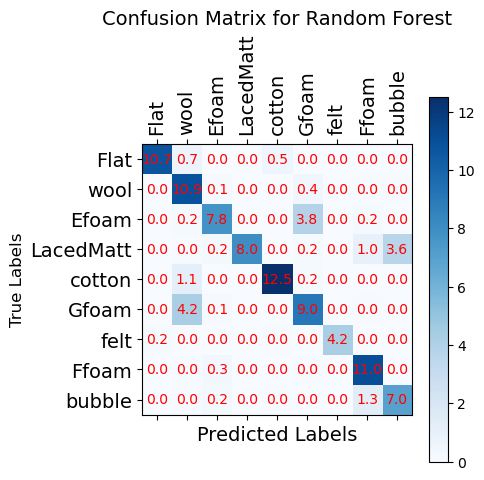

In [193]:
def compute_confusion_matrix(true_labels, pred_labels, num_classes):
    matrix = np.zeros((num_classes, num_classes), dtype=int)
    un=np.unique(test_y)
    for t, p in zip(true_labels, pred_labels):
        if p not in un: p=data.files.index(data.keys[find_nearest(un,p)])
        else: p=data.files.index(data.keys[int(p)])
        matrix[data.files.index(data.keys[t]), p] += 1
    matrix=matrix.astype(np.float64)
    matrix/=len(true_labels)
    return matrix
def find_nearest(array, value):
    # Calculate the absolute differences
    differences = np.abs(array - value)
    # Find the index of the minimum difference
    index_of_min = np.argmin(differences)
    # Return the value at that index in the original array
    return array[index_of_min]
# Combine all predictions
predictions = [predictionsC]
model_names = ['Random Forest', 'Linear Regression', 'Ridge Regression']
num_classes = len(np.unique(train_y))
un=np.unique(test_y)
indices = np.arange(num_classes)
# Plotting confusion matrices for each model
fig, axes = plt.subplots(1, len(predictions), figsize=(5*len(predictions), 5))

for i, preds in enumerate(predictions):
    cm = compute_confusion_matrix(test_y, preds, num_classes=len(np.unique(test_y)))
    
    ax = axes[i] if len(predictions) > 1 else axes
    cax = ax.matshow(cm*100, cmap='Blues')
    fig.colorbar(cax, ax=ax)
    
    for (j, k), value in np.ndenumerate(cm):
        ax.text(k, j, f'{round(value*100,1)}', ha='center', va='center', color='red')
    ax.set_title(f'Confusion Matrix for {model_names[i]}',fontsize=14)
    ax.set_xlabel('Predicted Labels',fontsize=14)
    ax.set_xticks(indices)
    ax.set_xticklabels([data.keys[np.unique(test_y)[j]] for j in range(num_classes)],rotation=90,fontsize=14)
    ax.set_ylabel('True Labels',fontsize=12)
    ax.set_yticks(indices)
    ax.set_yticklabels([data.keys[np.unique(test_y)[j]] for j in range(num_classes)],rotation=0,fontsize=14)

plt.tight_layout()
plt.savefig("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/images/confusionRandomFOrest.pdf")
plt.show()

##  cLASSIFICATION MODELS
### SVM

In [2]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

datapath="/its/home/drs25/Documents/data/Tactile Dataset/datasets/"
datapath="C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/texture-tactip/"
#load in numpy
data=np.load(datapath+"X_texture_all.npz")
for array_name in data:
    X=(data[array_name].astype(np.uint8))
data=np.load(datapath+"y_texture_all.npz")
for array_name in data:
    y=(data[array_name].astype(np.uint8))

encoder = OneHotEncoder(sparse_output=False)  # sparse_output=False returns a dense array
# Fit and transform the label data
onehot_labels = encoder.fit_transform(y.reshape(-1, 1))
print(onehot_labels[0])

X=X[:,:4].reshape((len(X),4*X.shape[2]*X.shape[3]))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, np.argmax(onehot_labels,axis=1).astype(np.uint8), test_size=0.2, random_state=42)
print(X_train.shape,y_train.shape)
# Standardize the features (important for SVM)
"""scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)"""

# Create an SVM classifier
svm_model = SVC(decision_function_shape='ovo')

# Train the SVM model
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test)
y_pred2 = svm_model.predict(X_train)

(6080, 52800) (6080,)


In [20]:
loss=np.abs(y_pred-y_test)
loss[loss>0]=1
correct=len(loss)-np.sum(loss)
print("Accuracy:",correct/len(loss))

loss=np.abs(y_pred2-y_train)
loss[loss>0]=1
correct=len(loss)-np.sum(loss)
print("Accuracy:",correct/len(loss))

Accuracy: 0.8868421052631579
Accuracy: 0.8855263157894737


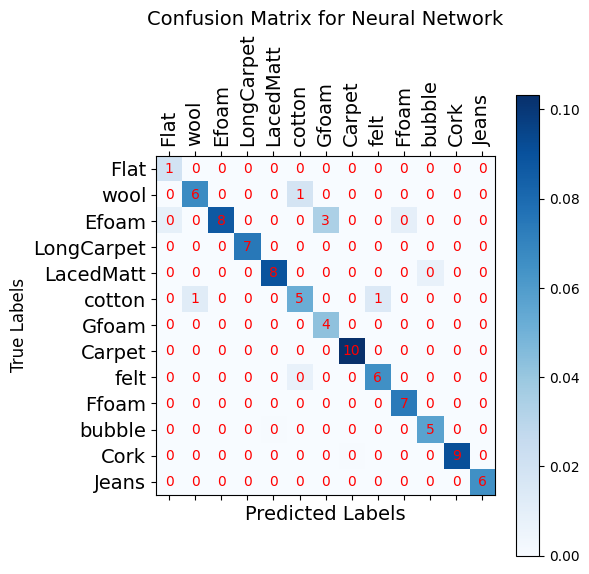

In [24]:
def compute_confusion_matrix(true_labels, pred_labels, num_classes):
    matrix = np.zeros((num_classes, num_classes), dtype=int)
    un=np.unique(y_test)
    for t, p in zip(true_labels, pred_labels):
        matrix[t, p] += 1
    return matrix/len(true_labels)
cat=encoder.categories_[0]
keys={'Cork': 38, 'wool': 19, 'LacedMatt': 28, 'Gfoam': 30, 'Carpet': 31, 'bubble': 37, 'Efoam': 21, 'cotton': 29, 'LongCarpet': 25, 'Flat': 16, 'felt': 34, 'Jeans': 39, 'Ffoam': 36}
inv_map = {v: k for k, v in keys.items()}  
predictions = [y_pred]
model_names = ['Neural Network']
num_classes = len(np.unique(y_test))
un=np.unique(y_pred)
indices = np.arange(num_classes)
# Plotting confusion matrices for each model
fig, axes = plt.subplots(1, len(predictions), figsize=(6, 6))

for i, preds in enumerate(predictions):
    cm = compute_confusion_matrix(y_pred, y_test, num_classes=len(np.unique(y_test)))
    
    ax = axes[i] if len(predictions) > 1 else axes
    cax = ax.matshow(cm, cmap='Blues')
    fig.colorbar(cax, ax=ax)
    
    for (j, k), value in np.ndenumerate(cm):
        ax.text(k, j, f'{int(value*100)}', ha='center', va='center', color='red')
    ax.set_title(f'Confusion Matrix for {model_names[i]}',fontsize=14)
    ax.set_xlabel('Predicted Labels',fontsize=14)
    ax.set_xticks(indices)
    ax.set_xticklabels([inv_map[cat[un[j]]] for j in range(num_classes)],rotation=90,fontsize=14)
    ax.set_ylabel('True Labels',fontsize=12)
    ax.set_yticks(indices)
    ax.set_yticklabels([inv_map[cat[un[j]]] for j in range(num_classes)],rotation=0,fontsize=14)

plt.tight_layout()
plt.savefig("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/images/SVM.pdf")
plt.show()

## MOdelling with points

(750, 10, 110, 120)
(750, 10, 110, 120) (750, 10, 260, 270)


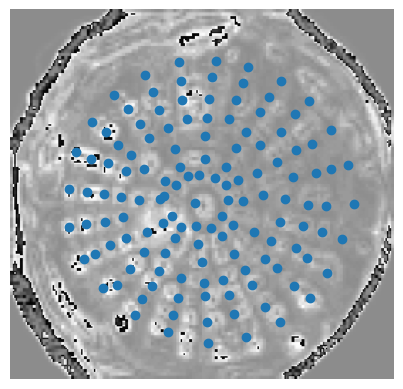

In [107]:
import pickle
with open('/its/home/drs25/Documents/GitHub/RoboSkin/Code/Models/TacTip reader/pickle_imputer_sobel.pkl','rb') as file:
    reg=pickle.load(file)

def predict(reg,dat):
    dat=dat.flatten()
    p=reg.predict([dat])
    p=p.reshape((p.shape[0],p.shape[1]//2,2))
    return p
sample=data.X[0:750]
print(sample.shape)
X_prime=np.zeros((len(sample),sample.shape[1],260,270),dtype=np.uint8)
coords=np.zeros((len(sample),sample.shape[1],133,2))
for i in range(len(sample)): #create data aas linear images
    for j in range(len(sample[0])):
        X_prime[i][j]=cv2.resize(sample[i][j],(270,260),interpolation=cv2.INTER_AREA)+140
        coords[i][j]=predict(reg,X_prime[i][j])[0]
X_alt=X_prime
X_alt[X_alt>255]=255
print(sample.shape,X_alt.shape)
plt.imshow(X_alt[0][0],cmap="gray")
pred=predict(reg,X_alt[0][0])[0]
plt.scatter(pred[:,0],pred[:,1])
plt.axis("off")
plt.savefig("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/images/transfertogel.pdf")
plt.show()

In [108]:
unique=[]
classes=np.unique(data.y[0:750])
for class_ in classes: #gather all the items of data
    unique.append(coords[np.where(data.y[0:750]==class_)])

averages=[]
stds=[]
for class_ in unique: #gather average movement for that class
    averages.append(np.average(class_,axis=0))
    stds.append(np.std(class_,axis=0))

In [138]:
def euclidean_distance(point1, point2):
    # Convert points to numpy arrays
    point1 = np.array(point1)
    point2 = np.array(point2)
    
    # Calculate the distance
    distance = np.linalg.norm(point1 - point2,axis=1)
    
    return distance

print(np.average(stds))

0.4861193821797396


(10, 133, 2) (10, 133, 2) 9


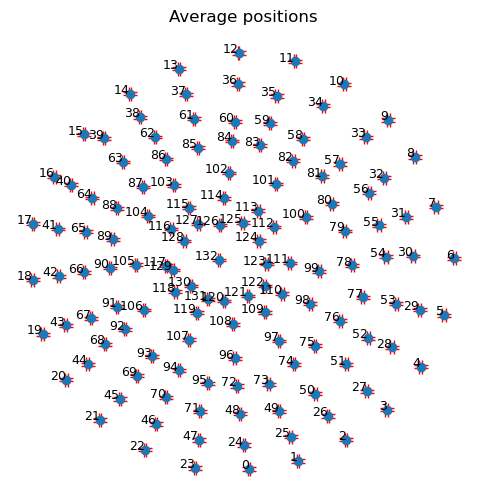

In [118]:
print(stds[0].shape,averages[0].shape,len(stds))
x_values, y_values = zip(*averages[8][0][:,])
std_x, std_y = zip(*stds[8][0])

# Plot the data
plt.figure(figsize=(10, 6))
plt.errorbar(x_values, y_values, xerr=std_x, yerr=std_y, fmt='o', ecolor='r', capsize=5, label='Data with Std Dev')
#plt.scatter(x_values, y_values)
# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Average positions')
#plt.legend()
# Add numbered labels to each point
for i, (x, y) in enumerate(zip(x_values, y_values)):
    plt.text(x, y, str(i), fontsize=9, ha='right')
plt.gca().set_aspect('equal', adjustable='box')
# Show plot
plt.axis("off")
plt.savefig("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/images/regressionPointsErrorBar.pdf")
plt.show()

1.7494005639627375
1.3896483514179758
0.9899359308615178
1.7792525356456395
1.310232617047245
1.3676283388134836
1.3934489451281236
1.615968446958976
1.5891262508110084


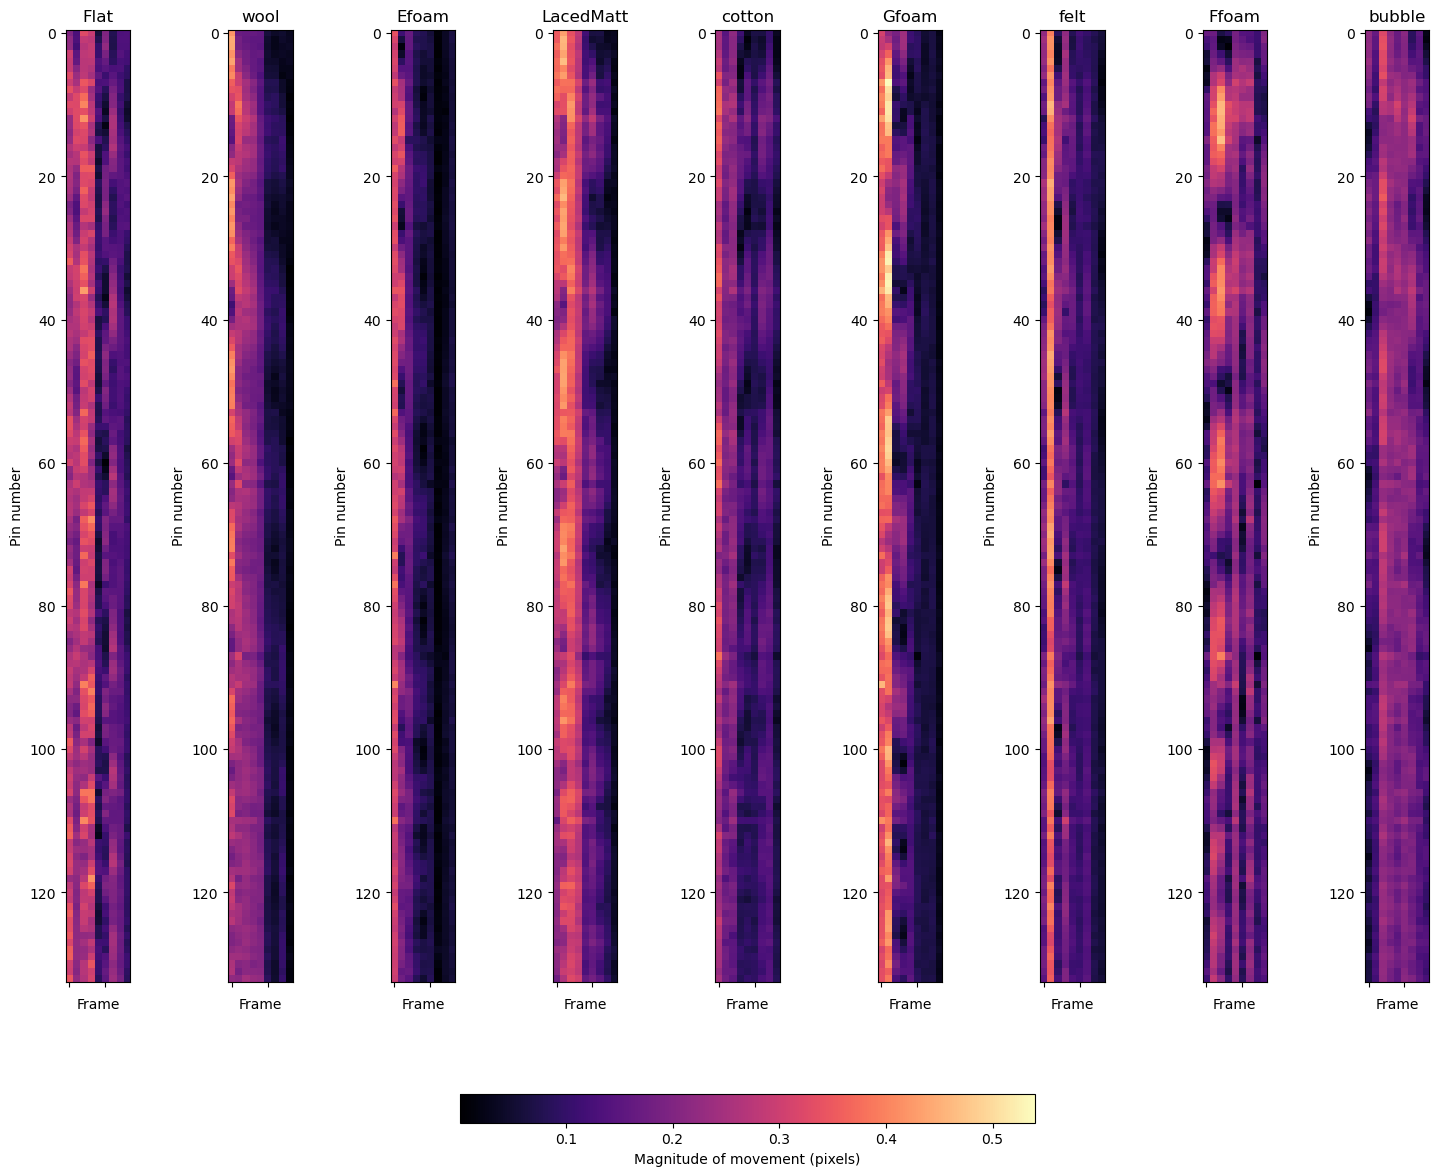

In [156]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

def plotchange(average):
    magnitudes=[]
    for t in range(len(average)-1):
        magnitudes.append(euclidean_distance(average[t],average[t+1]))
    ar=np.array(magnitudes).T
    return ar#(ar-np.min(ar))/(np.max(ar)-np.min(ar))

fig, axes = plt.subplots(1, len(averages), figsize=(15,12))
axes = axes.flatten()

all_magnitudes = np.concatenate([plotchange(avg) for avg in averages])
vmin = np.min(all_magnitudes)
vmax = np.max(all_magnitudes)
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = cm.magma
# Plot each set of averages
for i in range(len(averages)):
    m = plotchange(averages[i])
    print(np.average(np.sum(m,axis=1)))
    im = axes[i].imshow(m, norm=norm, cmap=cmap)
    axes[i].set_ylabel("Pin number")
    axes[i].set_xlabel("Frame")
    axes[i].set_xticklabels([])
    axes[i].set_title(data.keys[classes[i]])

# Add color bar at the bottom
plt.tight_layout()
cbar = fig.colorbar(im, ax=axes, orientation='horizontal', pad=0.1,fraction=0.05, shrink=0.4)
cbar.set_label('Magnitude of movement (pixels)')

plt.savefig("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/images/pinMovementsTexture.pdf")
plt.show()

(9, 133, 11)


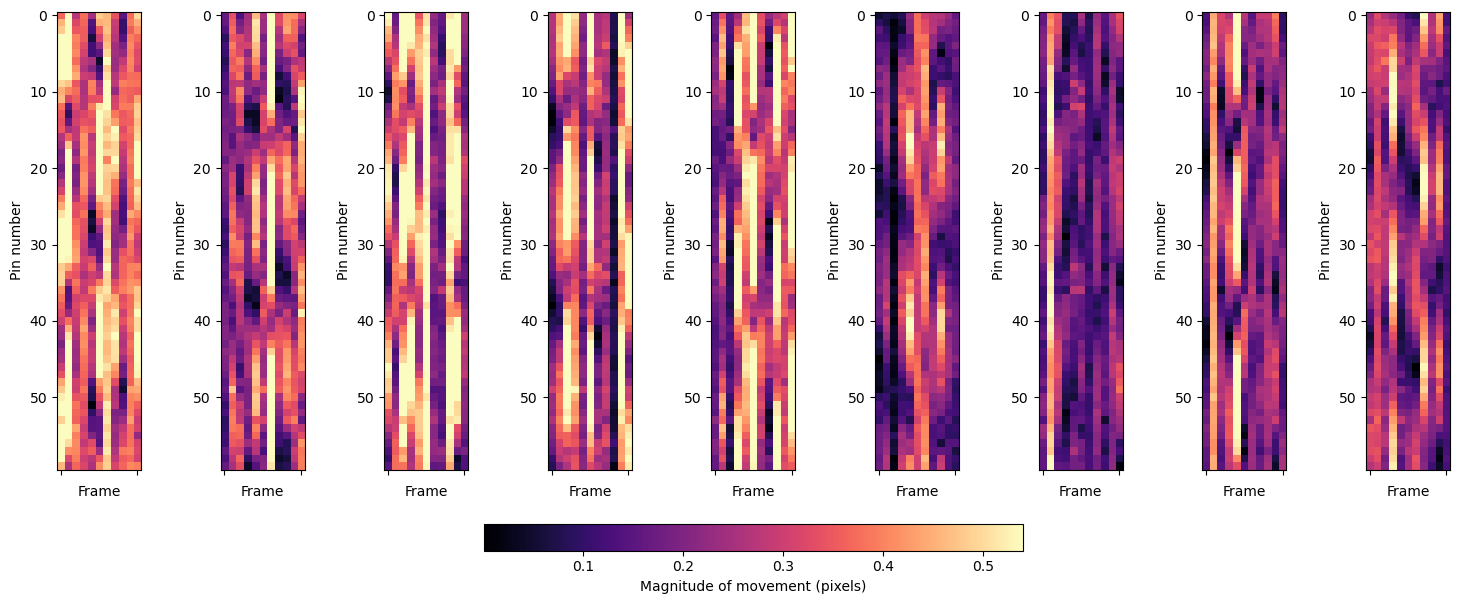

In [175]:
fig, axes = plt.subplots(1, len(averages), figsize=(15,6))
axes = axes.flatten()

all_magnitudes = np.array([plotchange(avg) for avg in unique[3][0:11]]).T
all_magnitudes = (all_magnitudes - np.min(all_magnitudes ))/(np.max(all_magnitudes )-np.min(all_magnitudes ))
#vmin = np.min(all_magnitudes)
#vmax = np.max(all_magnitudes)
#norm = Normalize(vmin=vmin, vmax=vmax)
#cmap = cm.magma
# Plot each set of averages
print(all_magnitudes.shape)
for i in range(len(averages)):
    im = axes[i].imshow(all_magnitudes[i][0:60], norm=norm, cmap=cmap)
    axes[i].set_ylabel("Pin number")
    axes[i].set_xlabel("Frame")
    axes[i].set_xticklabels([])

# Add color bar at the bottom
plt.tight_layout()
cbar = fig.colorbar(im, ax=axes, orientation='horizontal', pad=0.1,fraction=0.05, shrink=0.4)
cbar.set_label('Magnitude of movement (pixels)')

plt.savefig("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/images/pinMovementsTextureSame.pdf")
plt.show()